Basic idea of the notebook is to:

1. Test out functionality for implementing choice model log-likelihoods using Theano
2. Test out the feasibility of using PyMC3 to perform bayesian estimations of the choice models in PyLogit.

In [1]:
# For specifying the multinomial logit model
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Import the theano.tensor module for use in defining
import theano
import theano.tensor as tt
from theano import sparse

# Import pymc3 to test the DensityDist class with my custom
# log-likelihood function
import pymc3 as pm

# Make sure we can plot
import seaborn
import matplotlib.pyplot as plt

# Import PyLogit to instantiate the discrete choice models
import pylogit as pl

# Import utilities for plotting traces
import tim_learning_bayes as tlb

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Define the boundary values which are not to be exceeded during computation
# This is to prevent underflow and overflow.
min_exponent_val = -700
max_exponent_val = 700

max_comp_value = 1e300
min_comp_value = 1e-300

# Do not perform tests on the computational graph, because I have not provided
# test values for the objects of the graph. Note PyMC3 seems to enable
# computation of the test values by default.
theano.config.compute_test_value = 'off'

# Define symbols for the quantities that will be used in the various functions
# beta will be a 1D array with a shape (design.shape[0],) column
beta = tt.dvector('beta')
# design will be a 2D array with arbitrary numbers of rows and columns
design = tt.dmatrix('design')
# rows_to_obs will be a 2D compressed sparse row matrix. Note that this may not
# be the most efficient format to use, since I have more rows than columns, but
# I have to compute dot products with this variable so that seems to point to
# the use of compressed sparse rows
rows_to_obs = sparse.csr_matrix('rows_to_obs', dtype="int64")
# The choice vector will be a 2D array with one row. lrow specifies a dtype of
# int64 which seems like overkill, but I think this is the dtype of the default
# integer array from numpy.
choice_vector = tt.lrow('choice_vector')


def calc_mnl_probabilities(beta,
                           design,
                           rows_to_obs):
    """
    This function will calculate the MNL choice probabilities for each
    alternative of each choice situation in the design matrix. This function
    will be specific to ONLY the MNL model. Note this function is overly
    restrictive because Theano can only do automatic differentiation of
    functions that return scalars. This means the log-likelihood function
    must only return a single value, so this probability function must only
    return a 1D array (or a column vector in 2D).

    Parameters
    ----------
    beta : 1D ndarray of shape `(design.shape[1],)`.
        All elements should by ints, floats, or longs. There should be one
        element per index coefficient.
    design : 2D ndarray.
        There should be one row per observation per available alternative.
        There should be one column per utility coefficient being estimated. All
        elements should be ints, floats, or longs.
    rows_to_obs : 2D ndarray.
        There should be one row per observation per available alternative and
        one column per observation. This matrix maps the rows of the design
        matrix to the unique observations (on the columns).

    Returns
    -------
    long_probs : 1D ndarray of shape `(design.shape[0],)`.
        There will be one element per observation per available alternative for
        that observation. Each element will be the probability of the
        corresponding observation being associated with that rows corresponding
        alternative.
    """
    # Calculate the systematic utility for each alternative for each individual
    sys_utilities = design.dot(beta)

    # The following commands are to guard against numeric under/over-flow
    # Note that the strange function calls are used because Theano needs
    # special commands to emulate the (clearer) numpy behavior.
    sys_utilities = tt.switch(tt.lt(sys_utilities, min_exponent_val),
                              min_exponent_val,
                              sys_utilities)

    sys_utilities = tt.switch(tt.gt(sys_utilities, max_exponent_val),
                              max_exponent_val,
                              sys_utilities)

    # Exponentiate the transformed utilities
    long_exponentials = np.exp(sys_utilities)

    # Calculate \sum _j exp(V_j) for each individual.
    # Result should be a 1D array.
    individual_denominators = sparse.dot(sparse.transpose(rows_to_obs),
                                         long_exponentials)

    # Get a 1D array of the same number of rows as the design matrix, with each
    # element of each row representing the `individual_denominators` for the
    # given choice situation for the given observation.
    long_denominators = sparse.dot(rows_to_obs,
                                   individual_denominators)

    # long_probs will be of shape (num_rows,) Each element will provide the
    # probability of the observation associated with that row having the
    # alternative associated with that row as the observation's outcome
    long_probs = long_exponentials / long_denominators

    # Guard against underflow. Note the `.nonzero()` is so Theano can duplicate
    # the boolean slicing capabilities of numpy.
    long_probs = tt.switch(tt.eq(long_probs, 0), min_comp_value, long_probs)

    # Consider using an assert statement that ensures all probabilities add to
    # 1 for each choice situation.
    return long_probs


# Create the theano function for probability calculations
mnl_prob_args = (beta, design, rows_to_obs)
calc_theano_mnl_probs = theano.function(
                            inputs=[beta, design, rows_to_obs],
                            outputs=
                                calc_mnl_probabilities(*mnl_prob_args))


# Create the function that will calculate the log-likelihood for the MNL model
# This will be a symbolic function once we evaluate it on the Theano Tensor
# Variables.
def calc_log_likelihood_mnl(beta,
                            design,
                            rows_to_obs,
                            choice_vector):
    """
    This function will calculate the log-likelihood of an MNL model (and only
    an MNL model).

    Parameters
    ----------
    beta : 2D ndarray of shape `(design.shape[1],)`.
        All elements should by ints, floats, or longs. Should have 1 element
        for each utility coefficient being estimated (i.e. num_features).
    design : 2D ndarray.
        There should be one row per observation per available alternative.
        There should be one column per utility coefficient being estimated. All
        elements should be ints, floats, or longs.
    rows_to_obs : 2D ndarray.
        There should be one row per observation per available alternative and
        one column per observation. This matrix maps the rows of the design
        matrix to the unique observations (on the columns).
    choice_vector : 2D ndarray of shape `(1, design.shape[0])`.
        All elements should be either ones or zeros. There should be one column
        per observation per available alternative for the given observation.
        Elements denote the alternative which is chosen by the given
        observation with a 1 and a zero otherwise.

    Returns
    -------
    log_likelihood : float. The log likelihood of the multinomial logit model.
    """
    # Calculate the probability of each individual choosing each available
    # alternative for that individual.
    long_probs = calc_mnl_probabilities(beta,
                                        design,
                                        rows_to_obs)

    # Calculate the log likelihood
    log_likelihood = tt.dot(choice_vector, tt.log(long_probs))

    # Note that the log-likelihood is a (1, 1) array, so summing over
    # both axes does nothing but return the value at log_likelihood[0][0]
    # This is necessary because we need to return a scalar for the
    # automatic differentiation capabilities of Theano to work.
    return log_likelihood[0]


# Create the actual theano function for log-likelihood calculations.
mnl_log_like_args = [beta, design, rows_to_obs, choice_vector]
theano_mnl_log_likelihood = theano.function(
                            inputs=mnl_log_like_args,
                            outputs=
                                calc_log_likelihood_mnl(*mnl_log_like_args))

# Define a symbolic expression for the gradient of the log-likelihood function
gradient_beta = tt.grad(calc_log_likelihood_mnl(*mnl_log_like_args),
                        beta)
# Create a theano function to calculate the gradient of the log-likelihood
# function. Note that the symbolic expression--gradient_beta--relies on
# all of the same arguments as the log-likelihood function. These arguments
# must therefore be supplied for the function call.
theano_gradient = theano.function(mnl_log_like_args, gradient_beta)

# Define a symbolic expression for the hessian of the log-likelihood function
hessian_beta = theano.gradient.hessian(calc_log_likelihood_mnl(*mnl_log_like_args),
                                       beta)
# Create a theano function to calculate the hessiant of the log-likelihood
# function. Note that the symbolic expression--hessian_beta--relies on
# all of the same arguments as the log-likelihood function. These arguments
# must therefore be supplied for the function call.
theano_hessian = theano.function(mnl_log_like_args, hessian_beta)

# Test the probability function

In [3]:
fake_betas = np.array([-0.6])
fake_design = np.array([[1],
                        [2],
                        [3],
                        [1.5],
                        [3.5]])
fake_rows_to_obs = csr_matrix(np.array([[1, 0],
                                        [1, 0],
                                        [1, 0],
                                        [0, 1],
                                        [0, 1]]))
fake_choices = np.array([0, 1, 0, 0, 1])[None, :]

# Calculate the index vector
expected_index = fake_design.dot(fake_betas)
# Calculate exp(index)
expected_exp_index = np.exp(expected_index)
# Calculate the sum of exp(index) for each individual
denoms = fake_rows_to_obs.T.dot(expected_exp_index)
# Calculate the expected probabilities
expected_probs = expected_exp_index / fake_rows_to_obs.dot(denoms)
expected_probs

array([ 0.54053883,  0.296654  ,  0.16280717,  0.76852478,  0.23147522])

In [4]:
# Calculate the probabilities with the compiled theano function
calc_theano_mnl_probs(fake_betas,
                      fake_design,
                      fake_rows_to_obs)

array([ 0.54053883,  0.296654  ,  0.16280717,  0.76852478,  0.23147522])

# Test the log-likelihood function

In [5]:
# Calculate the log-likelihood with the compiled Theano function
# and look its type and value
log_like = theano_mnl_log_likelihood(fake_betas,
                                     fake_design,
                                     fake_rows_to_obs,
                                     fake_choices)
print type(log_like), log_like

<type 'numpy.ndarray'> -2.67847126751


In [6]:
# Calculate the log-likelihood 'by hand'
fake_choices.dot(np.log(expected_probs))

array([-2.67847127])

In [7]:
# Look at how we can extract a number from the zero--dimensional
# numpy array for the log-likelihood
float(log_like)

-2.6784712675077165

# Test the gradient function

In [8]:
# Calculate the gradient based on theano automatic differentiation
theano_gradient(fake_betas,
                fake_design,
                fake_rows_to_obs,
                fake_choices)

array([ 1.91478123])

In [9]:
# Calculate the analytic gradient. Note we use .ravel() because
# expected_probs is a column vector and fake_choices is a row vector
(fake_choices - expected_probs.ravel()).dot(fake_design)

array([[ 1.91478123]])

# Test the hessian function

In [10]:
# Calculate the hessian based on theano automatic differentiation
theano_hessian(fake_betas,
               fake_design,
               fake_rows_to_obs,
               fake_choices)

array([[-1.27224255]])

# Get real data from alternative link function paper

In [11]:
# Get the entire bay area chts file that I was using
# for the alternative link function paper
bay_area_chts_file = "spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv"
bay_area_chts = pd.read_csv(bay_area_chts_file)
bay_area_chts.columns

Index([u'household_id', u'person_id', u'tour_id', u'observation_id',
       u'mode_id', u'choice', u'tour_origin_taz', u'primary_dest_taz',
       u'total_travel_time', u'total_travel_cost', u'total_travel_distance',
       u'age', u'household_size', u'household_income',
       u'household_income_values', u'transit_subsidy',
       u'transit_subsidy_amount', u'num_cars', u'num_licensed_drivers',
       u'cross_bay', u'oakland_and_berkeley', u'survey_id', u'gender',
       u'non_relative_flag', u'num_pre_school', u'num_school_aged', u'married',
       u'parent', u'income_category_1', u'income_category_2',
       u'income_category_3', u'income_category_4', u'income_category_5',
       u'income_category_6', u'income_category_7', u'income_category_8',
       u'income_category_9', u'income_category_10', u'income_unknown',
       u'ln_drive_cost', u'ln_drive_cost_sq', u'total_travel_time_10x',
       u'total_travel_time_tenth', u'high_income', u'medium_income',
       u'low_income', u'high_i

# Estimate a penalized MNL model

In [12]:
# Scale the cost per distance and time so estimated coefs
# have closer orders of magnitude
bay_area_chts["cost_per_distance_10$_per_mi"] =\
    bay_area_chts["cost_per_distance"] * 10.0
    
bay_area_chts["total_travel_time_tenth_min"] =\
    bay_area_chts["total_travel_time"] / 10.0

In [13]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = range(2, 9)
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time_tenth_min"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time_tenth_min"] = ['Travel Time, units:0.1min (All Auto Modes)',
                                            'Travel Time, units:0.1min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance_10$_per_mi"] = [1, 2, 3]
mnl_names["cost_per_distance_10$_per_mi"] = ["Travel Cost per Distance, units:10$/mi (Drive Alone)",
                                             "Travel Cost per Distance, units:10$/mi (SharedRide-2)",
                                             "Travel Cost per Distance, units:10$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

In [14]:
# Instantiate the MNL model that corresponds to the specification above
mnl_model = pl.create_choice_model(data=bay_area_chts,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

# Figure out how many coefficients we're estimating
num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Perform penalized MLE on the model to get starting values for the MCMC
# Penalty comes from a stanfard deviation of 4 and a normal dist prior
# on each of the estimated coefficients.
# Penalty coef = 1/(2 * sigma^2) = 1/(2 * 16) = 1/32
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS",
                  ridge=1.0/32)

# Look at the estimation results
mnl_model.get_statsmodels_summary()

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/pylogit-0.1.2-py2.7.egg/pylogit/conditional_logit.py:344: UserWarning: NOTE: An L2-penalized regression is being performed. The reported standard errors and robust standard errors ***WILL BE INCORRECT***.


Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019
Estimation Time: 0.19 seconds.
Final log-likelihood: -5,076.8135


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Thu, 09 Mar 2017   Pseudo R-squ.:                   0.332
Time:                             12:48:43   Pseudo R-bar-squ.:               0.329
converged:                           False   Log-Likelihood:             -5,076.814
                                             LL-Null:                    -7,599.702
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                        -1.1800      0.473     -2.495      0.013        -2.107    -0.253
ASC Shared Ride: 3+                                        2.5851      0.992      2.606      0.009         0.641     4.530
ASC Walk-Transit-Walk                                     -0.3183      0.260     -1.225      0.221        -0.828     0.191
ASC Drive-Transit-Walk                                    -2.5467      0.275     -9.246      0.000        -3.087    -2.007
ASC Walk-Transit-Drive                                    -2.9011      0.279    -10.399      0.000        -3.448    -2.354
ASC Walk                                                   1.6291      0.276      5.907      0.000         1.089     2.170
ASC Bike                                                  -1.0278      0.276     -3.725      0.000        -1.569    -0.487
Travel Time, units:0.1min (All Auto Modes)                -0.7605      0.055    -13.793      0.000        -0.869    -0.652
Travel Time, units:0.1min (All Transit Modes)             -0.2756      0.021    -12.940      0.000        -0.317    -0.234
Travel Cost, units:$ (All Transit Modes)                  -0.1220      0.036     -3.376      0.001        -0.193    -0.051
Travel Cost per Distance, units:10$/mi (Drive Alone)      -0.4637      0.124     -3.747      0.000        -0.706    -0.221
Travel Cost per Distance, units:10$/mi (SharedRide-2)     -1.7988      0.441     -4.076      0.000        -2.664    -0.934
Travel Cost per Distance, units:10$/mi (SharedRide-3+)    -7.8111      1.363     -5.731      0.000       -10.482    -5.140
Autos per licensed drivers (All Auto Modes)                1.2126      0.128      9.489      0.000         0.962     1.463
Travel Distance, units:mi (Walk)                          -1.0264      0.050    -20.450      0.000        -1.125    -0.928
Travel Distance, units:mi (Bike)                          -0.2875      0.024    -11.922      0.000        -0.335    -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                        0.7625      0.322      2.369      0.018         0.132     1.393
Household Size (Shared Ride 2 & 3+)                        0.1145      0.045      2.546      0.011         0.026     0.203
Number of Kids in Household (Shared Ride 2 & 3+)           0.6867      0.054     12.828      0.000         0.582     0.792
==========================================================================================================================
"""

# Test out PyMC3

In [15]:
# Get the rows_to_obs mapping for this dataset.
# We typecast the object because Theano is expecting an int64 dtype
chts_rows_to_obs = mnl_model.get_mappings_for_fit()["rows_to_obs"].astype(int)

# Get the design matrix used for this dataset
chts_design = mnl_model.design

# Get the vector of choices used for this dataset
# and shape it into a row vector for Theano
# We typecast the object because Theano is expecting an int64 dtype
chts_choices_row = mnl_model.choices[None, :].astype(int)

In [16]:
# Create my own likelihood class for the MNL
class BayesianMNL(pm.Continuous):
    def __init__(self,
                 coefs,
                 default_value,
                 *args, **kwargs):
        """
        Parameters
        ----------
        coefs : PyMC3 random variable.
            Should contain the coefficients we'll use to calculate the
            log-likelihood.
        default_value : 1D ndarray.
            Should specify the value of the parameters to be estimated to be
            used in function testing. Ideally this would also be point of
            highest likelihood.
        """
        # Store the PyMC3 Random variables that will be used to compute the
        # log-likelihood. By storing a PyMC3 random variable, this distribution
        # will be updated whenever the PyMC3 random variable is updated. The idea
        # came from the example of how the likelihood worked in normal linear
        # regression. There, we never had to explicitly send
        self.coefs = coefs

        # Initialize Theano Symbolic Variables for the likelihood expression
        self.design = tt.dmatrix('design')
        self.rows_to_obs = sparse.csr_matrix('rows_to_obs', dtype="int64")
        self.choice_vector = tt.lrow('choice_vector')
        
        # Set the expected shape of the likelihood function's
        # input values
        kwargs['shape'] = default_value.shape
        
        # Carry out the typical Continuous distribution instantiation
        super(BayesianMNL, self).__init__(*args, **kwargs)
        
        # Store the 'mean' and mode of the likelihood expression
        # I do this just for compatibility with the typical Continuous
        # distribution.
        self.mean = default_value
        self.mode = default_value
        
        return None
        
    def logp(self,
             design=None,
             rows_to_obs=None,
             choice_vector=None):
        """
        Function that returns a Theano expression for the log-likelihood.
        
        Parameters
        ----------
        value : a Theano Variable.
            This variable should symbolically represent the parameters used
            to calculate the log-likelihood.
            
        Returns
        -------
        A Theano expression for the log-likelihood.
        """
        # The use of kwargs allows the user to pass in observables
        # If a user doesn't pass in a desired Theano Variable based
        # on observables, then fall back to the Theano Variables defined
        # at model instantiation
        if design is None:
            design = self.design
        if rows_to_obs is None:
            rows_to_obs = self.rows_to_obs
        if choice_vector is None:
            choice_vector = self.choice_vector

        return calc_log_likelihood_mnl(self.coefs,
                                       design,
                                       rows_to_obs,
                                       choice_vector)

In [17]:
# Do not perform tests on the computational graph, because I have not provided
# test values for the objects of the graph. Note PyMC3 seems to enable
# computation of the test values by default.
theano.config.compute_test_value = 'off'

# Instantiate the bayesian mnl model
bayesian_mnl = pm.Model()

# determine how many draws should be taken
num_draws = 2000

with bayesian_mnl:
    # Instantiate the priors for the MNL. Note shape=num_vars
    # will ensure that we have one normal distribution prior
    # for each coefficient being estimated
    mnl_beta = pm.Normal('mnl_beta', mu=0, sd=4, shape=num_vars)
    
    # Get the default value for this distribution. Use the MAP
    # estimate found using PyLogit
    default = mnl_model.params.values
    
    # Create the likelihood function / distribution
    likelihood = BayesianMNL("likelihood",
                             coefs=mnl_beta,
                             default_value=default,
                             observed={"design": chts_design,
                                       "rows_to_obs": chts_rows_to_obs,
                                       "choice_vector": chts_choices_row})
    
    # Find the MAP estimate
    map_estimate = pm.find_MAP()

    # Sample from the posterior
    trace = pm.sample(num_draws,
                      start=map_estimate,
                      random_seed=25)

self.coefs.type == TensorType(float64, vector)
         Current function value: 5120.612937
         Iterations: 40
         Function evaluations: 57
         Gradient evaluations: 56


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -5,170.6: 100%|██████████| 200000/200000 [05:35<00:00, 595.74it/s]
Finished [100%]: Average ELBO = -5,170
INFO:pymc3:Finished [100%]: Average ELBO = -5,170
100%|██████████| 2000/2000 [20:37<00:00,  1.62it/s]


# Analyze the traces

In [18]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.columns = mnl_model.params.index

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


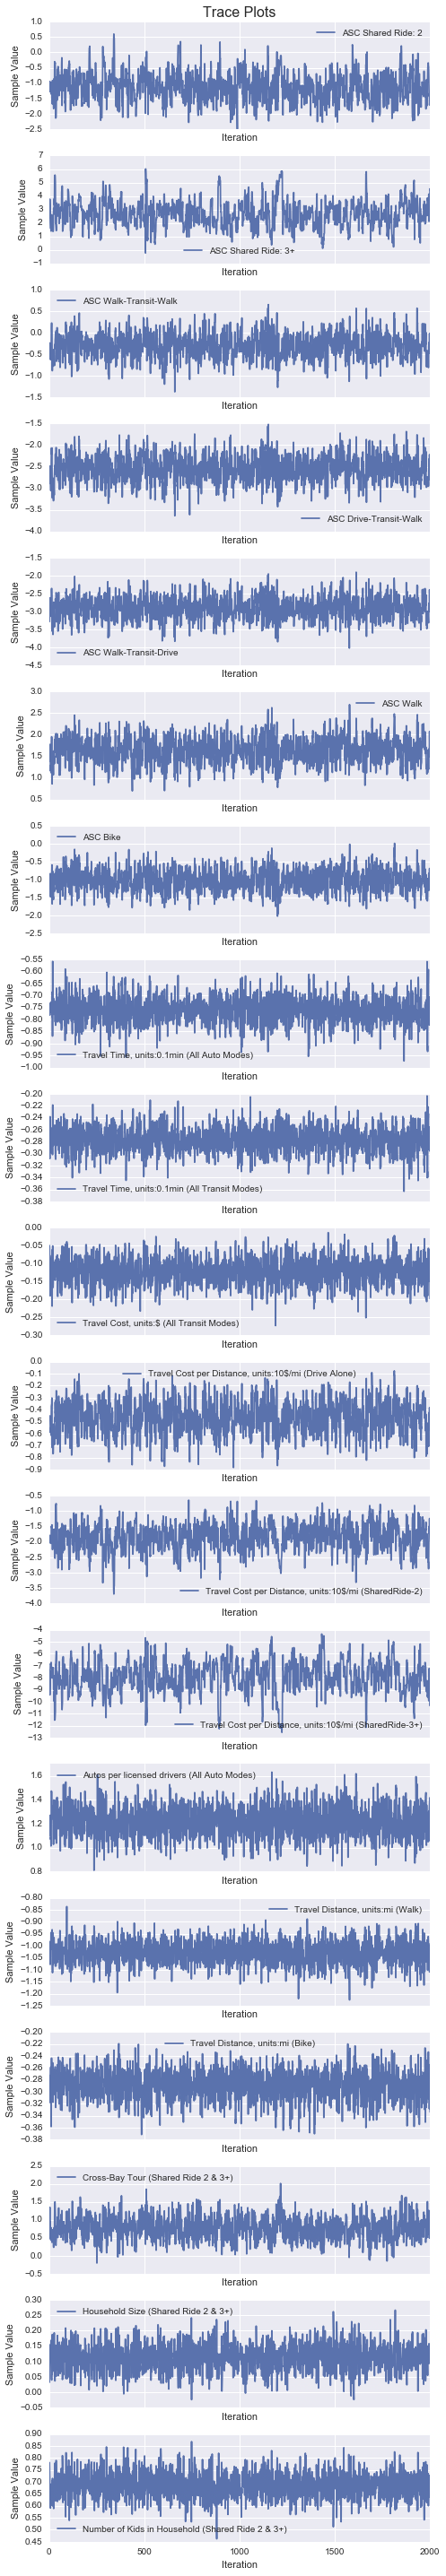

In [19]:
# Look at the trace plots from the samples
tlb.make_trace_plot(trace_df.values,
                    trace_df.columns,
                    figsize=(7, 40),
                    title="Trace Plots")

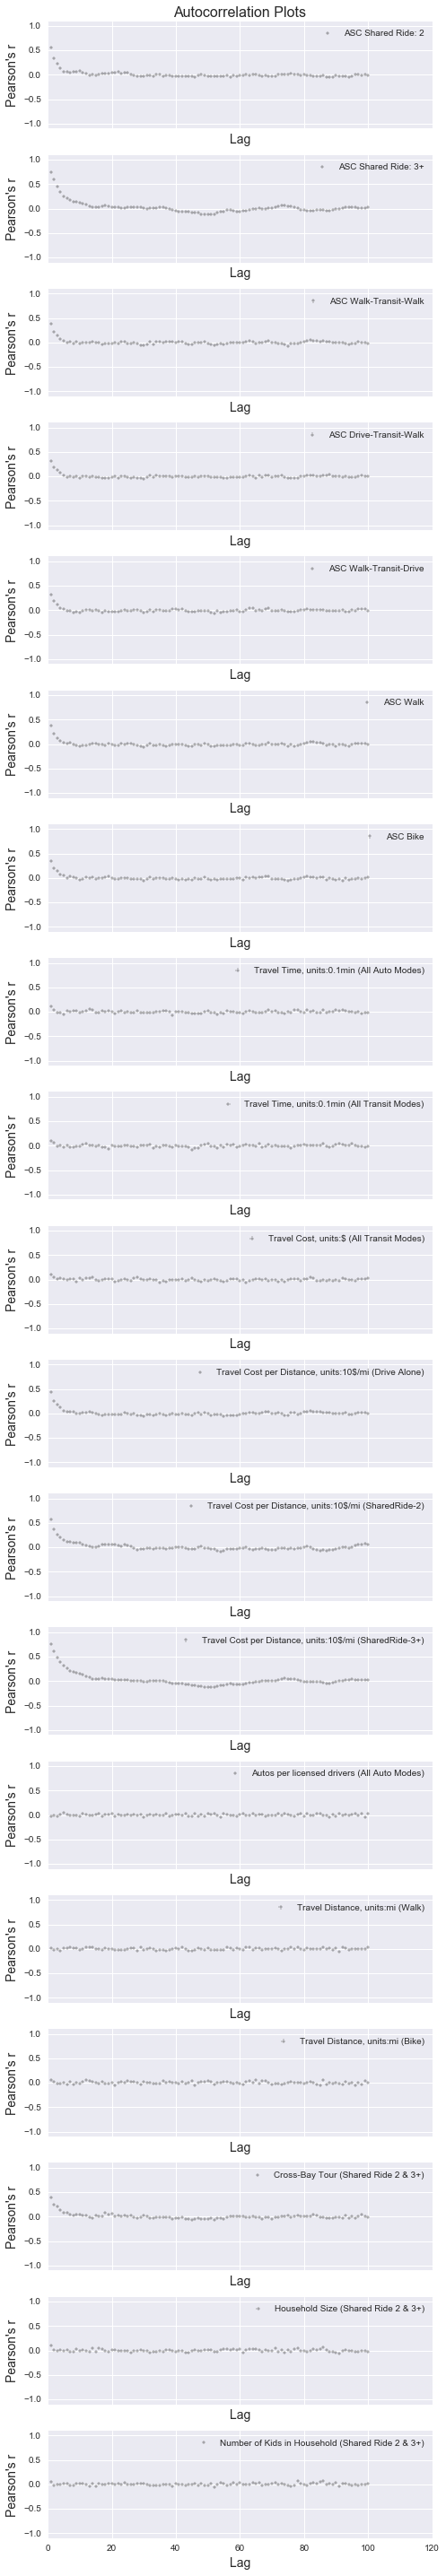

In [20]:
 # Look at the autocorrelation plots from the samples
tlb.make_autocorrelation_plot(trace_df.values,
                              trace_df.columns,
                              100,
                              figsize=(7, 40),
                              marker='+',
                              title="Autocorrelation Plots")

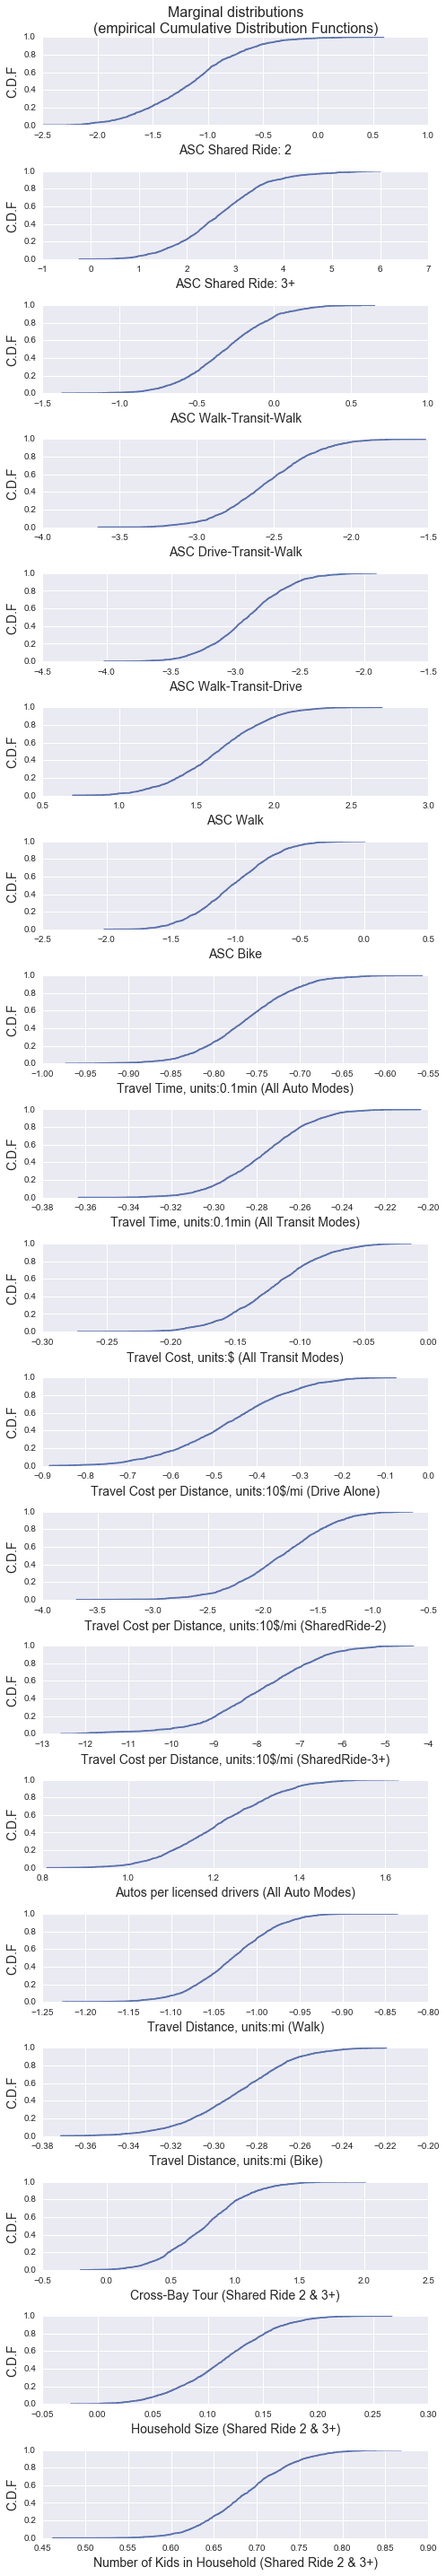

In [21]:
# View a plot of the empirical cdf of the samples
title = "Marginal distributions\n(empirical Cumulative Distribution Functions)"
tlb.make_empirical_cdf_plot(trace_df.values,
                            trace_df.columns,
                            figsize=(7, 40),
                            title=title)

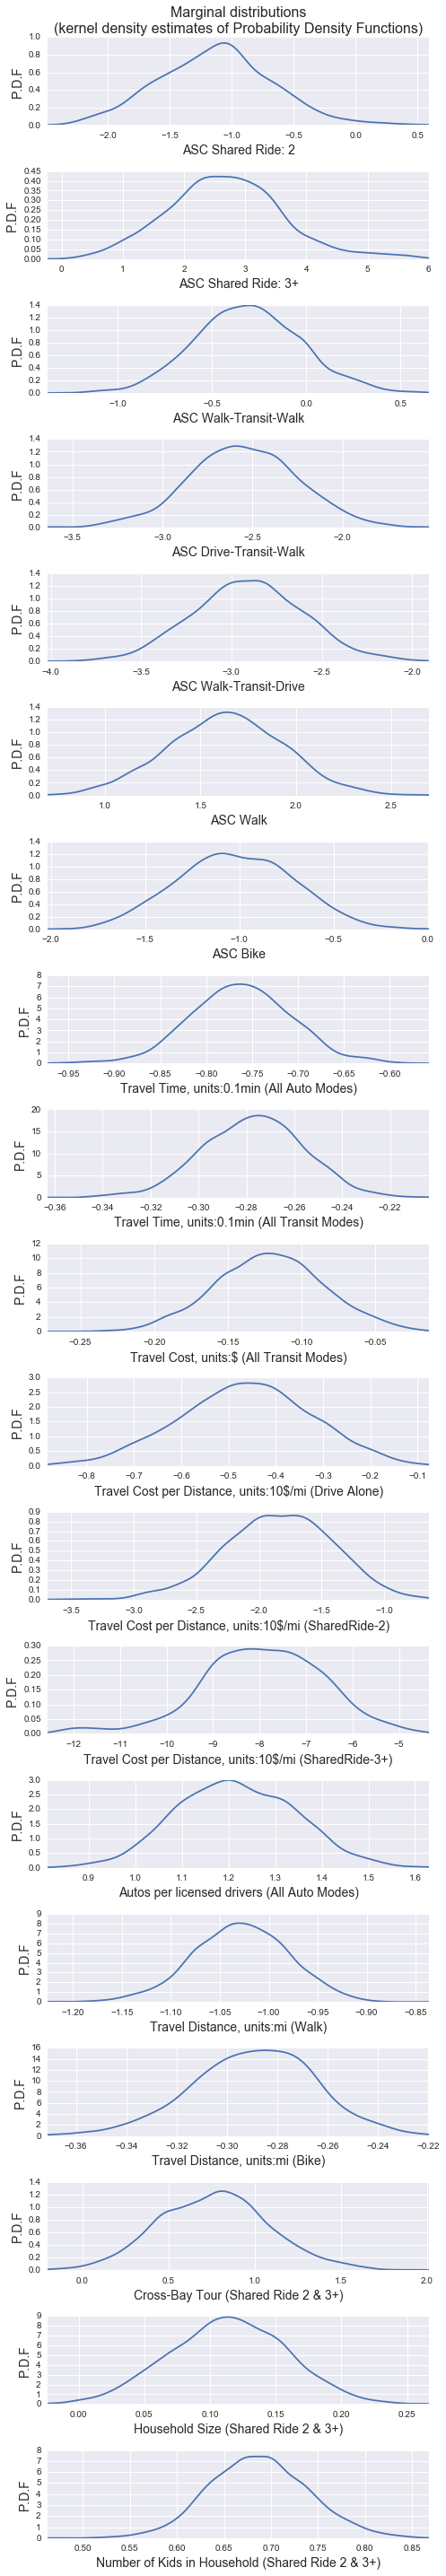

In [22]:
# Viewgeneric plot of the KDE of the marginal distributions in the samples
title = "Marginal distributions\n(kernel density estimates of Probability Density Functions)"
tlb.make_marginal_dist_kde_plot(trace_df.values,
                                trace_df.columns,
                                figsize=(7, 40),
                                title=title)

In [23]:
# Look at a summary of the traces
pm.summary(trace)


mnl_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -1.131           0.461            0.021            [-2.105, -0.310]
  2.686            0.958            0.056            [0.832, 4.679]
  -0.309           0.284            0.010            [-0.854, 0.253]
  -2.548           0.299            0.010            [-3.156, -1.967]
  -2.907           0.307            0.010            [-3.547, -2.356]
  1.633            0.304            0.011            [1.062, 2.247]
  -1.021           0.310            0.011            [-1.636, -0.460]
  -0.762           0.056            0.001            [-0.873, -0.653]
  -0.277           0.021            0.001            [-0.317, -0.236]
  -0.122           0.037            0.001            [-0.196, -0.051]
  -0.464           0.139            0.005            [-0.723, -0.190]
  -1.845           0.437            0.021            [-2.673, -0.977]
  -7.946  

In [24]:
# Look at the correlations between the various sampled coefficients
trace_df.corr()

,ASC Shared Ride: 2,ASC Shared Ride: 3+,ASC Walk-Transit-Walk,ASC Drive-Transit-Walk,ASC Walk-Transit-Drive,ASC Walk,ASC Bike,"Travel Time, units:0.1min (All Auto Modes)","Travel Time, units:0.1min (All Transit Modes)","Travel Cost, units:$ (All Transit Modes)","Travel Cost per Distance, units:10$/mi (Drive Alone)","Travel Cost per Distance, units:10$/mi (SharedRide-2)","Travel Cost per Distance, units:10$/mi (SharedRide-3+)",Autos per licensed drivers (All Auto Modes),"Travel Distance, units:mi (Walk)","Travel Distance, units:mi (Bike)",Cross-Bay Tour (Shared Ride 2 & 3+),Household Size (Shared Ride 2 & 3+),Number of Kids in Household (Shared Ride 2 & 3+)
ASC Shared Ride: 2,1.000000,0.433122,0.153081,0.151453,0.123766,0.133477,0.136480,-0.021755,-0.050849,0.056070,0.160202,-0.807073,-0.344879,0.005341,0.024637,0.012336,0.560838,-0.265951,0.114739
ASC Shared Ride: 3+,0.433122,1.000000,-0.002979,0.006347,-0.012488,-0.042960,-0.024981,-0.057203,-0.043183,-0.063887,-0.029609,-0.407996,-0.957509,-0.002085,0.022522,-0.046415,0.540936,-0.135939,0.057780
ASC Walk-Transit-Walk,0.153081,-0.002979,1.000000,0.894284,0.875984,0.810892,0.787047,-0.338390,-0.444564,0.111767,0.822892,0.316221,0.221543,0.293221,-0.111213,-0.165008,0.017558,-0.003233,0.016494
ASC Drive-Transit-Walk,0.151453,0.006347,0.894284,1.000000,0.814557,0.769221,0.749277,-0.216891,-0.346495,0.150520,0.763817,0.282853,0.196148,0.296753,-0.081023,-0.110362,0.019002,0.007098,0.001245
ASC Walk-Transit-Drive,0.123766,-0.012488,0.875984,0.814557,1.000000,0.754966,0.742038,-0.197132,-0.321074,0.147198,0.742570,0.299030,0.209799,0.298073,-0.071984,-0.108349,0.015515,-0.001456,0.010017
ASC Walk,0.133477,-0.042960,0.810892,0.769221,0.754966,1.000000,0.845021,-0.117248,-0.212837,0.332469,0.808904,0.319976,0.253303,0.352876,-0.386479,-0.124028,0.030162,0.018807,0.032490
ASC Bike,0.136480,-0.024981,0.787047,0.749277,0.742038,0.845021,1.000000,-0.065217,-0.168718,0.337727,0.792143,0.309699,0.232593,0.339092,-0.070950,-0.387539,0.037753,0.006937,0.027087
"Travel Time, units:0.1min (All Auto Modes)",-0.021755,-0.057203,-0.338390,-0.216891,-0.197132,-0.117248,-0.065217,1.000000,0.657799,0.453202,-0.278980,-0.116327,-0.008315,0.094376,0.300611,0.423085,-0.088179,-0.027410,-0.007505
"Travel Time, units:0.1min (All Transit Modes)",-0.050849,-0.043183,-0.444564,-0.346495,-0.321074,-0.212837,-0.168718,0.657799,1.000000,-0.176318,-0.325769,-0.119062,-0.038020,0.085310,0.202211,0.298311,-0.080492,-0.007939,-0.028864
"Travel Cost, units:$ (All Transit Modes)",0.056070,-0.063887,0.111767,0.150520,0.147198,0.332469,0.337727,0.453202,-0.176318,1.000000,0.311226,0.121618,0.146066,0.060764,0.131011,0.179223,0.074522,-0.007605,0.000374


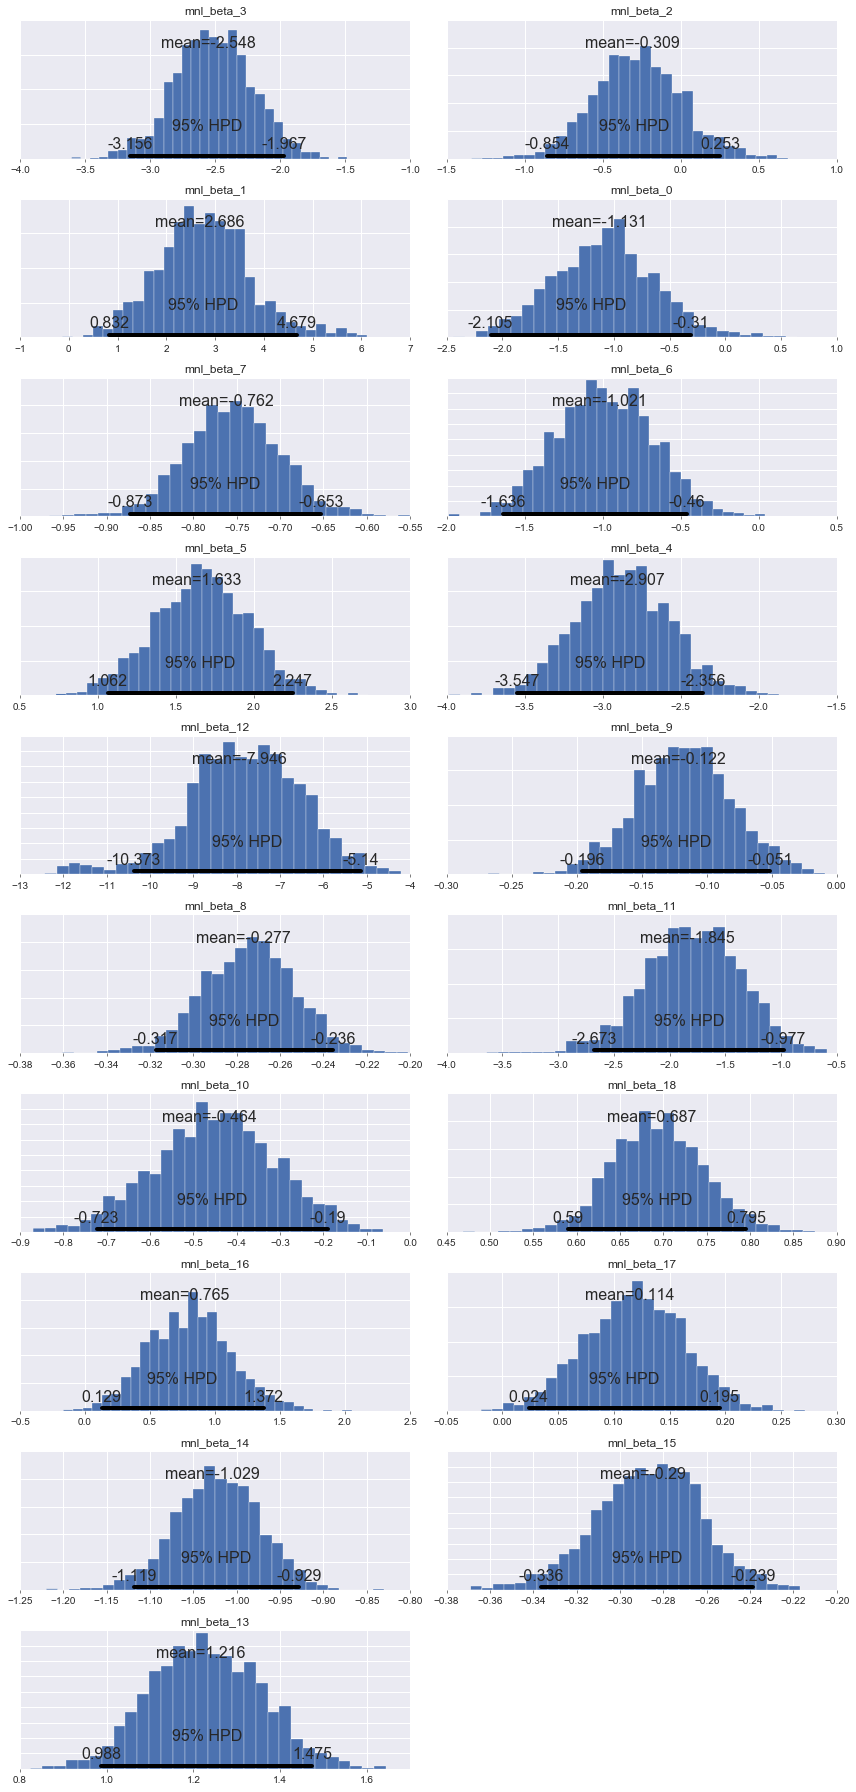

In [25]:
# Look at the traces based on PyMC3's plotting function
pm.plot_posterior(trace);